Testing code for validating the base policy

In [1]:
import torch
import torch.nn as nn  # noqa: F401
import numpy as np
from tqdm import tqdm

import safety_gymnasium

from rl_vcf.rl.algos.sac.core import MLPActorCritic
from rl_vcf.rl.utils import make_env_safety, get_actor_structure, process_info
from rl_vcf.validate.utils import ScenarioDatabase, estimate_epsilon

In [2]:
num_envs = 8
max_episode_length = 1000
num_scenarios = 1000

In [3]:
# Initialize scenario information database
scenario_database = ScenarioDatabase(num_envs, max_episode_length, num_scenarios)

In [4]:
print(scenario_database.active_scenarios)
print(scenario_database.timesteps)
print(scenario_database.scenario_data[1][999:])
print(max(scenario_database.active_scenarios))

[0 1 2 3 4 5 6 7]
[0 0 0 0 0 0 0 0]
[False False]
7


In [5]:
# ---
# TESTING:
# This is where task success flags for the active scenarios are found
goal_achieved = np.full(num_envs, False, dtype=bool)
# This is where the done flags are found
constraint_violated = np.full(num_envs, False, dtype=bool)

# Randomly generate task success flags
p_goal = 0.01
# Randomly generate done flags (term | trunc)
p_viol = 0.0002
# ---

# VALIDATION LOOP:

# Instantiate progress bar
pbar = tqdm(total=scenario_database.num_scenarios)
# While we haven't collected all required scenarios
while any(scenario_database.active_scenarios < scenario_database.num_scenarios):
    # ---
    # TESTING: environment step (and goal achieved reasoning) will go here
    # Randomly generate viol flag (represents constraint violation)
    constraint_violated = np.random.rand(num_envs) < p_viol
    # Randomly generate goal flag (represents goal achievement)
    goal_achieved = np.random.rand(num_envs) < p_goal
    # If the goal was achieved or constraint violated, mark the task as done
    done = np.logical_or(constraint_violated, goal_achieved)
    # If the agent has reached the maximum episode length, mark the task as done
    done = np.logical_or(
        done, scenario_database.timesteps == scenario_database.max_episode_length
    )
    # ---

    previous_active_scenarios = scenario_database.active_scenarios.copy()

    scenario_database.update(done, goal_achieved, constraint_violated)

    num_scenarios_complete = sum(
        previous_active_scenarios != scenario_database.active_scenarios
    )
    pbar.update(num_scenarios_complete)

    # ---
    goal_achieved = np.full(num_envs, False, dtype=bool)
    constraint_violated = np.full(num_envs, False, dtype=bool)
    # ---

# Close progress bar
pbar.close()

print(scenario_database.get_num_successes())
print(scenario_database.get_num_failures())

100%|██████████| 1000/1000 [00:00<00:00, 8118.77it/s]

[ 13  22  29 ... 982 982 982]
[987 978 971 ...  18  18  18]


In [6]:
print(scenario_database.active_scenarios)
print(scenario_database.timesteps)

[1003 1005 1000 1002 1004 1001 1006 1007]
[0 0 0 0 0 0 0 0]


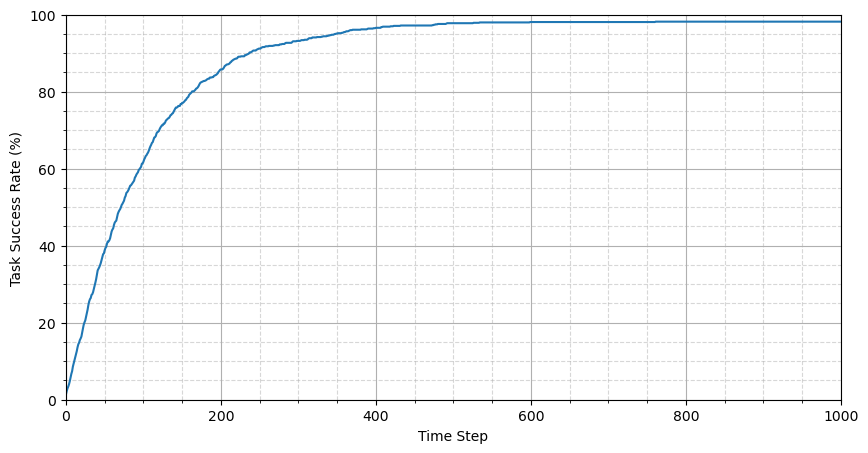

In [7]:
import matplotlib.pyplot as plt

# Plot task success rate
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(scenario_database.get_num_successes() / scenario_database.num_scenarios * 100)
ax.set_xlim([0, max_episode_length])
ax.set_ylim([0, 100])
ax.set_xlabel("Time Step")
ax.set_ylabel("Task Success Rate (%)")
ax.minorticks_on()
ax.grid(which="major")
ax.grid(which="minor", linestyle="--", alpha=0.5)

In [8]:
N_test = 10
k_test = 9
conf_test = 0.95
epsilon_test = estimate_epsilon(conf_test, N_test, k_test)
print(epsilon_test)

0.9948838031081764


In [9]:
# Test numerical result for epsilon
import math

conf = 0.99
k = 3

epsilon = estimate_epsilon(conf, num_scenarios, k, it_max=100, tol=1e-5)
print(epsilon)

test_beta = sum(
    math.comb(num_scenarios, i) * (epsilon**i) * ((1 - epsilon) ** (num_scenarios - i))
    for i in range(k + 1)
)
test_conf = 1 - test_beta
print(test_conf)

0.01001739501953125
0.9900560675132372


In [10]:
epsilons = scenario_database.get_all_epsilons(0.99)

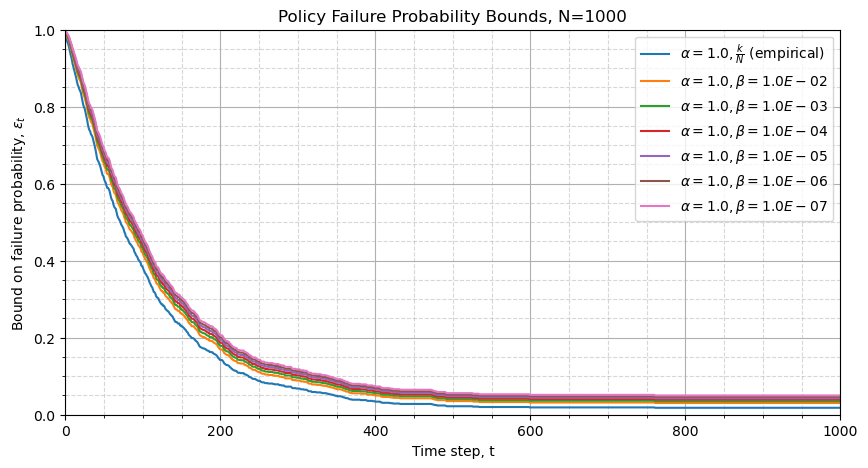

In [11]:
fig, ax = scenario_database.plot_epsilons(
    plot_empirical=True,
    confs=[0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.9999999],
)

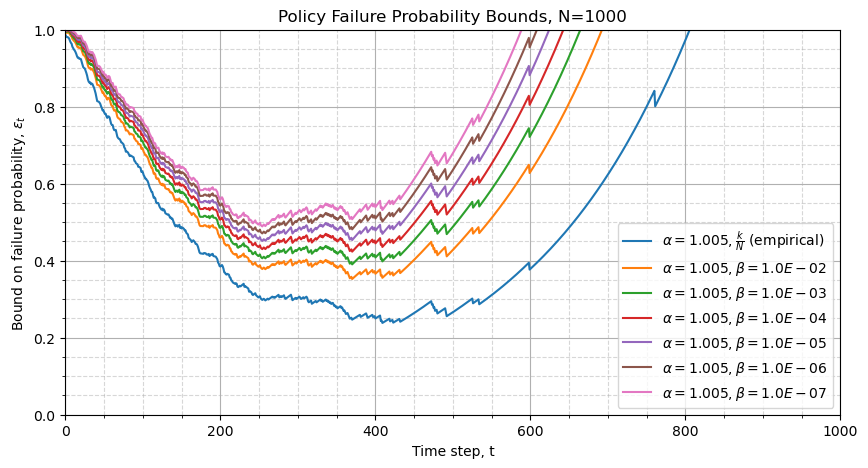

In [12]:
fig, ax = scenario_database.plot_epsilons(
    plot_empirical=True,
    confs=[0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.9999999],
    alphas=[1.005],
)

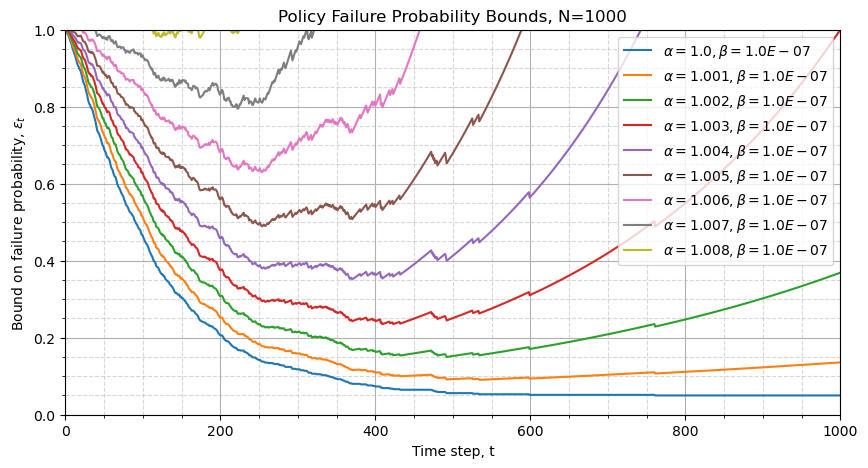

In [13]:
fig, ax = scenario_database.plot_epsilons(
    plot_empirical=False,
    confs=[0.9999999],
    alphas=[1.0, 1.001, 1.002, 1.003, 1.004, 1.005, 1.006, 1.007, 1.008],
)

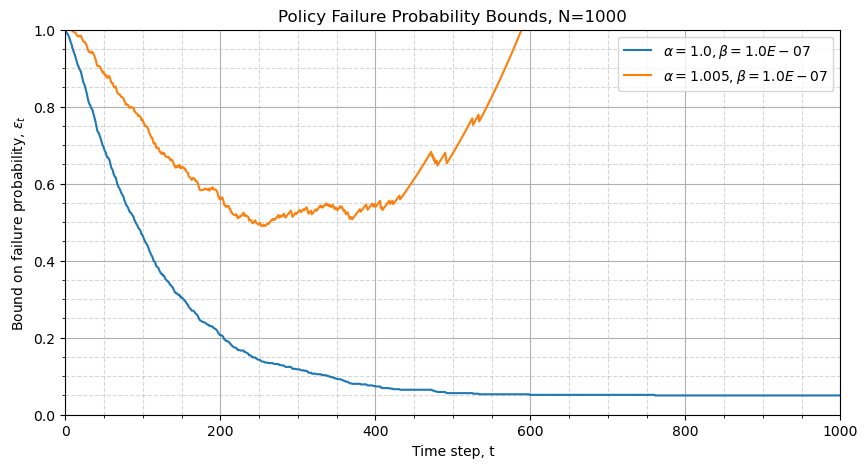

In [14]:
fig, ax = scenario_database.plot_epsilons(
    plot_empirical=False,
    confs=[0.9999999],
    alphas=[1.0, 1.005],
)

In [15]:
print(
    scenario_database.get_selected_epsilons(t_steps=[10, 45, 100, 900], conf=0.9999999)
)

[0.94696045 0.72098541 0.46400452 0.0500412 ]


In [16]:
scenario_database.update(
    [True, False, True, False, True, False, True, False],
    [False, False, False, False, False, False, False, False],
    [True, True, True, True, True, True, True, True],
)

In [17]:
seed = 0
device = "cuda"
rl_num_scenarios = 1000
envs = safety_gymnasium.vector.SafetySyncVectorEnv(
    [
        make_env_safety(
            "SafetyPointReachAvoidReset0-v0",
            i,
            seed + i,
            False,
            5,
            False,
        )
        for i in range(num_envs)
    ]
)

In [18]:
# Load state dict
loaded_state_dict = torch.load(
    "rl-policy-episode-200.pt", weights_only=True, map_location=device
)

# Construct agent from state dict
loaded_hidden_sizes, loaded_activation = get_actor_structure(
    loaded_state_dict, envs.single_observation_space, envs.single_action_space
)

agent = MLPActorCritic(
    envs.single_observation_space,
    envs.single_action_space,
    loaded_hidden_sizes,
    eval("nn." + loaded_activation + "()"),
)
agent.pi.load_state_dict(loaded_state_dict, strict=True)
agent.to(device)

# Prevent storing gradients
for p in agent.parameters():
    p.requires_grad = False

In [20]:
obs, info = envs.reset(seed=[seed + i for i in range(num_envs)])
print(info)
with torch.no_grad():
    while "final_info" not in info:
        act = agent.act(torch.Tensor(obs).to(device))
        next_obs, rew, cost, term, trunc, info = envs.step(act.detach().cpu().numpy())
        done = np.logical_or(term, trunc)
        obs = next_obs
print(info)
goal_achieved, constraint_violated = process_info(info)
print(goal_achieved)
print(constraint_violated)
print(done)

{}
{'cost_sum': array([0., 0., 0., 0., 0., 0., 0., 0.]), '_cost_sum': array([ True,  True, False,  True,  True,  True,  True,  True]), 'constraint_violated': array([False, False, False, False, False, False, False, False]), '_constraint_violated': array([ True,  True, False,  True,  True,  True,  True,  True]), 'goal_met': array([False, False, False, False, False, False, False, False]), '_goal_met': array([ True,  True, False,  True,  True,  True,  True,  True]), 'final_observation': array([None, None,
       array([ 0.83251815, -6.56230919,  9.81      ,  1.07919988, -0.14814167,
               0.        ,  0.        ,  0.        ,  1.0571701 , -0.36049752,
               0.34647012,  0.        ,  0.90414997,  0.07468001,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.82946996])                         ,
       None, None,

In [21]:
obs, info = envs.reset(seed=[seed + i for i in range(num_envs)])
print(info)
with torch.no_grad():
    while "final_info" not in info:
        act = 0 * envs.action_space.sample()
        next_obs, rew, cost, term, trunc, info = envs.step(act)
        done = np.logical_or(term, trunc)
        obs = next_obs
print(info)
goal_achieved, constraint_violated = process_info(info)
print(goal_achieved)
print(constraint_violated)
print(done)

{}
{'final_observation': array([array([ 0.        ,  0.        ,  9.81      ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,  0.48291542,
              -0.12958664,  0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,  0.23644382,
               0.64703953,  0.41059571,  0.        ])                         ,
       array([ 0.        ,  0.        ,  9.81      ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        , -0.39843437,
              -0.30207624,  0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,  0.51239117,
               0.73581873,  0.22342756,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ])                         ,
       array([ 0.        

In [ ]:
rl_scenario_database = ScenarioDatabase(num_envs, max_episode_length, rl_num_scenarios)

obs, info = envs.reset(seed=[seed + i for i in range(num_envs)])

done = np.full(num_envs, False, dtype=bool)
goal_achieved = np.full(num_envs, False, dtype=bool)
rl_scenario_database.update(done, goal_achieved)

# VALIDATION LOOP:

# Instantiate progress bar
pbar = tqdm(total=rl_scenario_database.num_scenarios)
with torch.no_grad():  # no gradient needed for testing
    while any(
        rl_scenario_database.active_scenarios < rl_scenario_database.num_scenarios
    ):

        act = agent.act(torch.Tensor(obs).to(device))

        next_obs, rew, cost, term, trunc, info = envs.step(act.detach().cpu().numpy())

        done = np.logical_or(term, trunc)
        goal_achieved, constraint_violated = process_info(info)

        obs = next_obs
        previous_active_scenarios = rl_scenario_database.active_scenarios.copy()

        rl_scenario_database.update(done, goal_achieved, constraint_violated)

        num_scenarios_complete = sum(
            previous_active_scenarios != rl_scenario_database.active_scenarios
        )
        pbar.update(num_scenarios_complete)

# Close progress bar
pbar.close()

100%|██████████| 1000/1000 [12:36<00:00,  1.32it/s]

{'cost_sum': array([0., 0., 0., 0., 0., 0., 0., 0.]), '_cost_sum': array([ True, False,  True,  True,  True,  True,  True,  True]), 'constraint_violated': array([False, False, False, False, False, False, False, False]), '_constraint_violated': array([ True, False,  True,  True,  True,  True,  True,  True]), 'goal_met': array([False, False, False, False, False, False, False, False]), '_goal_met': array([ True, False,  True,  True,  True,  True,  True,  True]), 'final_observation': array([None,
       array([  0.73996971, -12.10614074,   9.81      ,   1.15446313,
                0.01694091,   0.        ,  -0.        ,   0.        ,
               -1.96004805,   0.40586089,   0.29202215,   0.        ,
                0.81035723,   0.        ,   0.        ,   0.        ,
                0.        ,   0.        ,   0.        ,   0.        ,
                0.        ,   0.        ,   0.        ,   0.        ,
                0.        ,   0.        ,   0.09050199,   0.90085922]),
       Non

In [69]:
print(rl_scenario_database.active_scenarios)
print(rl_scenario_database.get_num_successes())
print(rl_scenario_database.get_num_failures())

[1005 1007 1004 1001 1002 1006 1003 1000]
[   0    0    0 ... 1000 1000 1000]
[1000 1000 1000 ...    0    0    0]


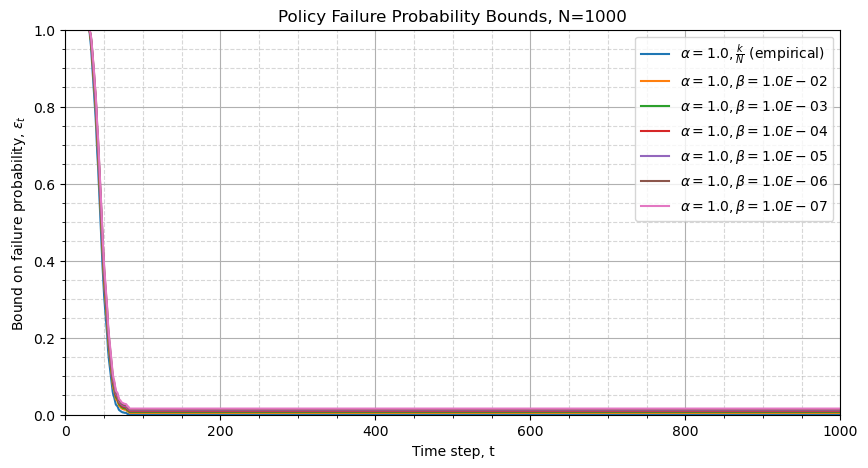

In [70]:
fig, ax = rl_scenario_database.plot_epsilons(
    plot_empirical=True,
    confs=[0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.9999999],
)

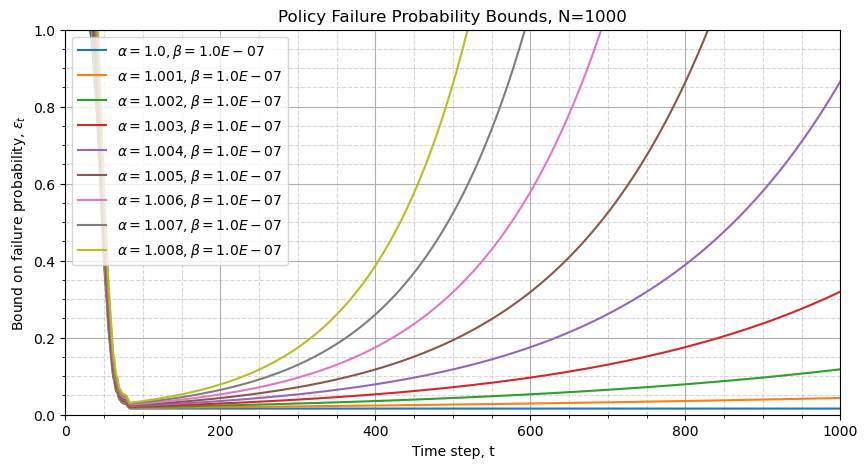

In [72]:
fig, ax = rl_scenario_database.plot_epsilons(
    plot_empirical=False,
    confs=[0.9999999],
    alphas=[1.0, 1.001, 1.002, 1.003, 1.004, 1.005, 1.006, 1.007, 1.008],
)